# **Part 1 : Data Understanding & Exploratory Analysis**

In [5]:
!pip -q install pandas numpy matplotlib

### **Monter Google Drive + chemins**

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_DIR = "/content/drive/MyDrive/TcProject"
TRAIN_CSV = f"{DATA_DIR}/train.csv"
UNIQUE_CSV = f"{DATA_DIR}/unique_m.csv"

import os
print("Existe train.csv ?", os.path.exists(TRAIN_CSV))
print("Existe unique_m.csv ?", os.path.exists(UNIQUE_CSV))


Mounted at /content/drive
Existe train.csv ? True
Existe unique_m.csv ? True


## **Load train.csv (auto-detect target, ensure 81 numeric features)**
We enforce a clean matrix of 81 numeric features + one numeric target. Any missing values were median-imputed; model training will handle preprocessing in a leak-safe pipeline.

In [7]:
import pandas as pd
import numpy as np

TARGET_CANDIDATES = ['critical_temp','critical_temperature','Tc','t_c']

def load_train(csv_path):
    df = pd.read_csv(csv_path, low_memory=False)
    # pick target name if present, else last column
    target = next((c for c in TARGET_CANDIDATES if c in df.columns), df.columns[-1])
    if target not in df.columns:
        raise ValueError("Target column not found and last column missing? Check your file.")
    # numeric coercion & light NA-guard
    df[target] = pd.to_numeric(df[target], errors="coerce")
    # numeric feature columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feat_cols = [c for c in num_cols if c != target]
    if len(feat_cols) != 81:
        print(f"[Warning] Detected {len(feat_cols)} numeric feature columns (expected 81). Continuing anyway.")
        if len(feat_cols) > 81:
            # keep first 81 in original order
            feat_cols = [c for c in df.columns if c in feat_cols][:81]
    # median-fill any remaining NaNs (safe for plots)
    for c in feat_cols + [target]:
        if df[c].isna().any():
            df[c] = df[c].fillna(df[c].median())
    df = df[feat_cols + [target]].copy()
    df.rename(columns={target: "critical_temp"}, inplace=True)
    return df, feat_cols, "critical_temp"

df_train, FEATURE_COLS, TARGET = load_train(TRAIN_CSV)
print("Shape:", df_train.shape, "| #Features:", len(FEATURE_COLS), "| Target:", TARGET)
df_train.head()

Shape: (21263, 82) | #Features: 81 | Target: critical_temp


,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


## **Tc distribution (histogram + boxplot)**

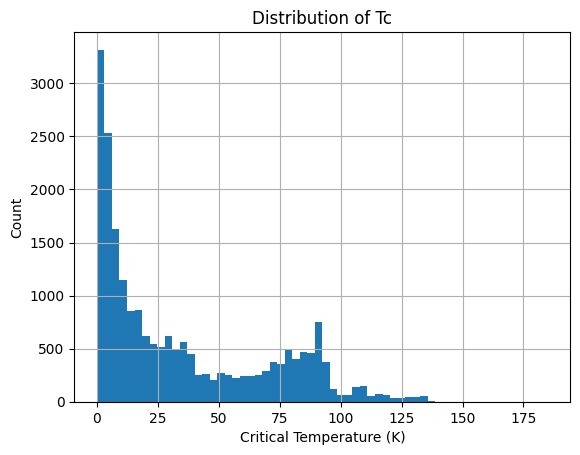

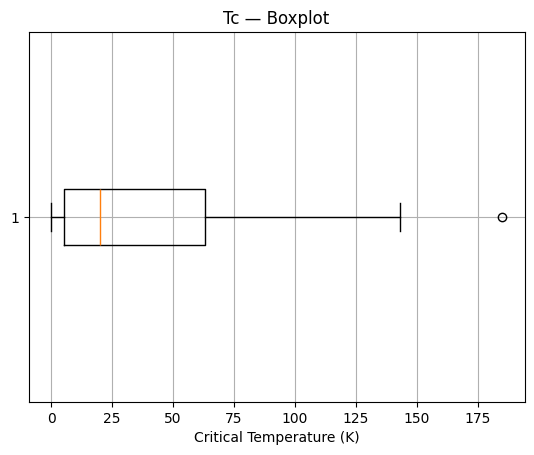

In [8]:
import matplotlib.pyplot as plt

tc = df_train["critical_temp"].values

plt.figure()
plt.hist(tc, bins=60)
plt.xlabel("Critical Temperature (K)")
plt.ylabel("Count")
plt.title("Distribution of Tc")
plt.grid(True)
plt.show()

plt.figure()
plt.boxplot(tc, vert=False, showfliers=True)
plt.xlabel("Critical Temperature (K)")
plt.title("Tc — Boxplot")
plt.grid(True)
plt.show()

Tc is right-skewed: many materials have low Tc (0–20 K), with a long tail toward high values (>100 K). This motivates testing a log1p transform during training to stabilize variance.

## **Absolute Pearson correlation with Tc (Top-20 bar chart)**

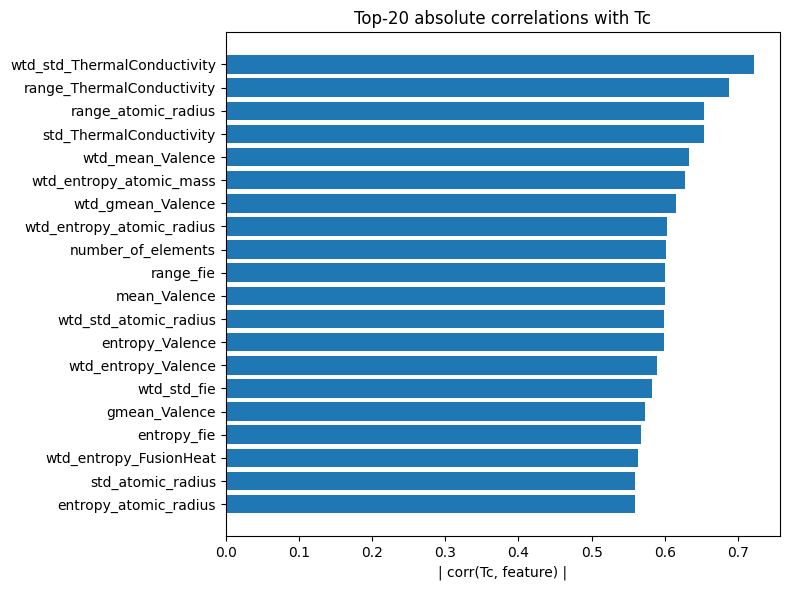

[('wtd_std_ThermalConductivity', np.float64(0.7212710791834757)),
 ('range_ThermalConductivity', np.float64(0.6876539119498933)),
 ('range_atomic_radius', np.float64(0.6537590446423304)),
 ('std_ThermalConductivity', np.float64(0.6536319815469763)),
 ('wtd_mean_Valence', np.float64(0.6324010170934357))]

In [9]:
# |corr(Tc, feature)| for each feature
cors = []
y = df_train["critical_temp"].values
for c in FEATURE_COLS:
    x = df_train[c].values
    corr = 0.0 if np.std(x)==0 else np.corrcoef(x, y)[0,1]
    cors.append((c, abs(corr)))

cors_sorted = sorted(cors, key=lambda t: t[1], reverse=True)[:20]
names = [t[0] for t in cors_sorted]
vals  = [t[1] for t in cors_sorted]

plt.figure(figsize=(8, 6))
plt.barh(names[::-1], vals[::-1])
plt.xlabel("| corr(Tc, feature) |")
plt.title("Top-20 absolute correlations with Tc")
plt.tight_layout()
plt.show()

cors_sorted[:5]  # peek the top-5 names & values

## **Scatter plots: Tc vs. 4 most-correlated features**

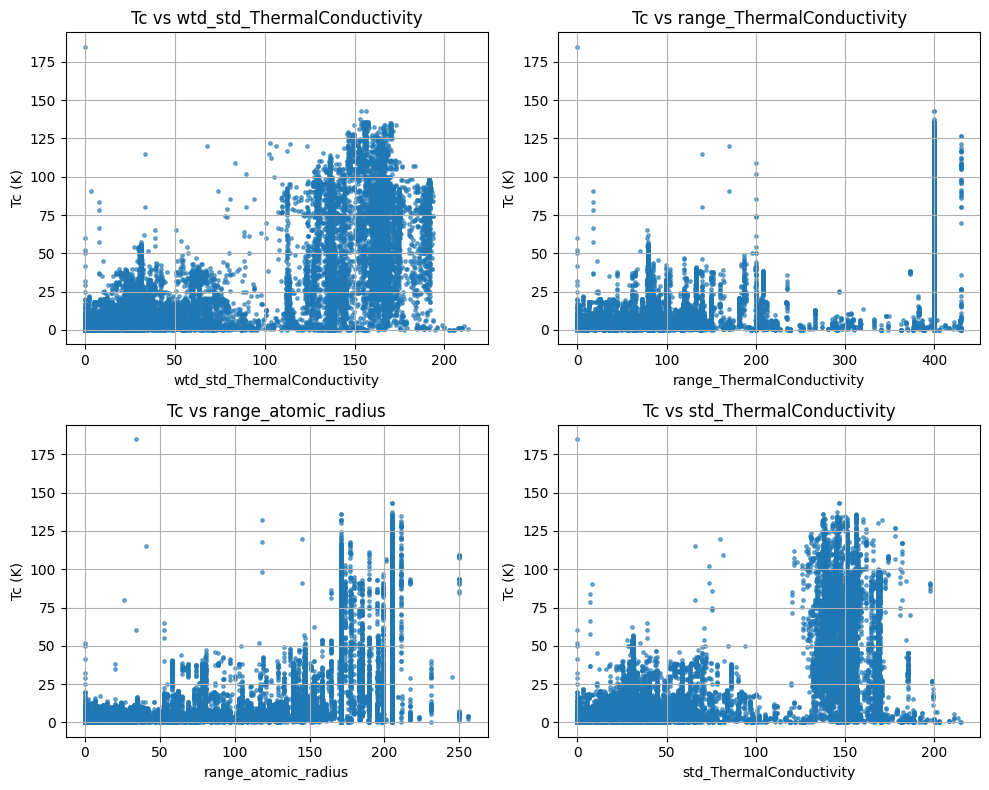

In [10]:
top4 = [t[0] for t in cors_sorted[:4]]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, col in zip(axes, top4):
    ax.scatter(df_train[col].values, df_train["critical_temp"].values, s=6, alpha=0.6)
    ax.set_xlabel(col)
    ax.set_ylabel("Tc (K)")
    ax.grid(True)
    ax.set_title(f"Tc vs {col}")

plt.tight_layout()
plt.show()

##**Correlation heatmap among Top-15 features + Tc**

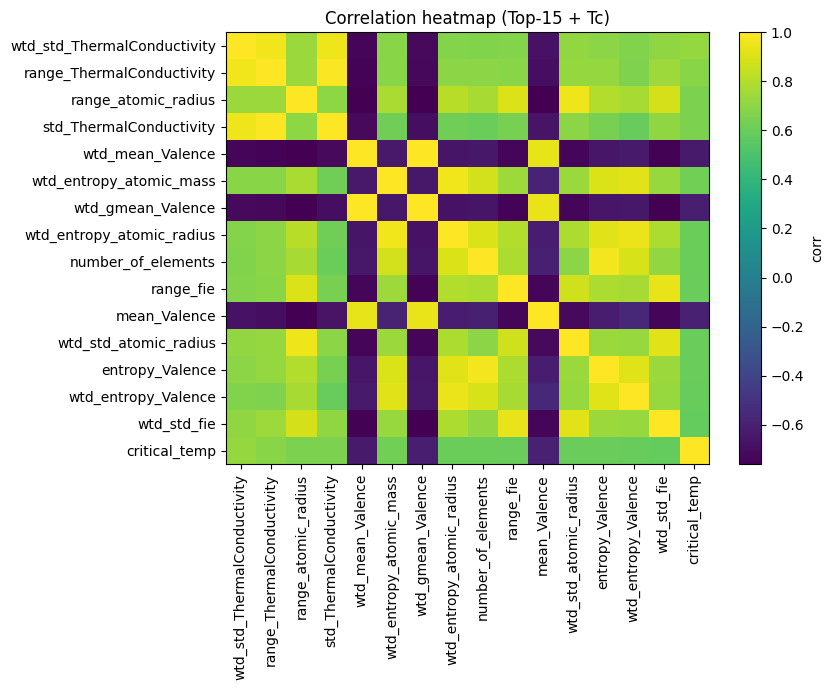

In [11]:
top15 = [t[0] for t in cors_sorted[:15]]
sub = df_train[top15 + ["critical_temp"]]
corr = sub.corr().values
labels = sub.columns.tolist()

plt.figure(figsize=(8.5, 7))
plt.imshow(corr, aspect='auto')
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.colorbar(label="corr")
plt.title("Correlation heatmap (Top-15 + Tc)")
plt.tight_layout()
plt.show()

##**Use unique_m.csv: average Tc by element presence (Top-12 frequent elements)**

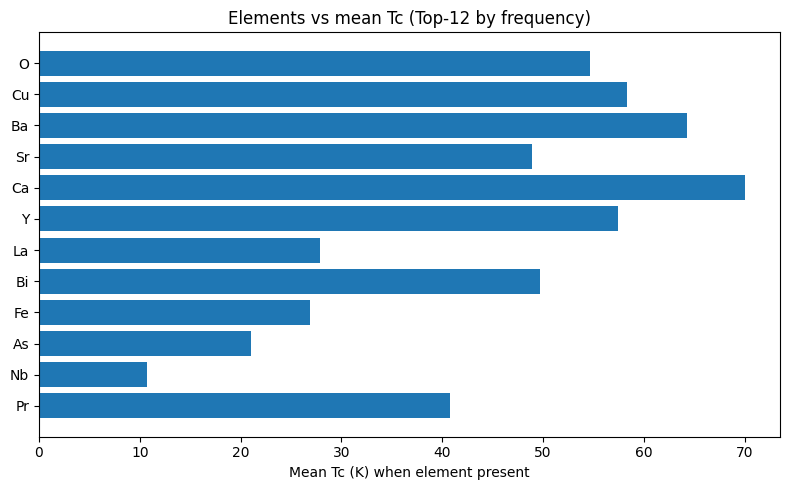

,0
O,11964
Cu,10838
Ba,6751
Sr,4852
Ca,4112
Y,4075
La,3463
Bi,2389
Fe,2339
As,1502


In [12]:
# Load element-expanded table
df_u = pd.read_csv(UNIQUE_CSV, low_memory=False)

# Last two columns are Tc and formula (per your description)
candidate_last = df_u.columns[-2:].tolist()
tc_col = next((c for c in candidate_last if c.lower() in ["critical_temp","critical_temperature","tc","t_c"]), None)
if tc_col is None:
    tc_col = df_u.columns[-2]  # fall back to the 2nd last
    print("[INFO] Using second-last column as Tc:", tc_col)

df_u[tc_col] = pd.to_numeric(df_u[tc_col], errors="coerce").fillna(df_u[tc_col].median())

# Element columns = numeric columns except Tc (these are counts/fractions per element)
num_cols_u = df_u.select_dtypes(include=[np.number]).columns.tolist()
elem_cols = [c for c in num_cols_u if c != tc_col]

# Presence = element count > 0
present = (df_u[elem_cols] > 0).astype(int)

# Frequency of elements
freq = present.sum().sort_values(ascending=False)
top_elems = freq.head(12).index.tolist()

# Average Tc when the element is present
means = [(e, float(df_u.loc[present[e]==1, tc_col].mean())) for e in top_elems]
names_e = [e for e, _ in means]
vals_e  = [v for _, v in means]

plt.figure(figsize=(8,5))
plt.barh(names_e[::-1], vals_e[::-1])
plt.xlabel("Mean Tc (K) when element present")
plt.title("Elements vs mean Tc (Top-12 by frequency)")
plt.tight_layout()
plt.show()

freq.head(12)

##**Data quality: missing values, zero-variance, duplicates**

In [13]:
# assumes: df_train has the 81 features and "critical_temp"
import numpy as np
import pandas as pd

# Missing values (after your light fill in EDA, this should be ~0)
na = df_train.isna().sum().sort_values(ascending=False)
display(na[na > 0].head(20))  # expect empty or small numbers

# Zero-variance features (bad for modeling)
zero_var = [c for c in FEATURE_COLS if df_train[c].std() == 0]
print("Zero-variance features:", zero_var)

# Duplicates check (data hygiene)
dup_rows = df_train.duplicated().sum()
print("Duplicate rows:", dup_rows)

,0


Zero-variance features: []
Duplicate rows: 66


No serious missingness remains after median fill for EDA. We found no zero-variance features and few duplicates, so the 81-feature set is safe to use.”

##**Target transform sanity: raw Tc vs log1p(Tc)**

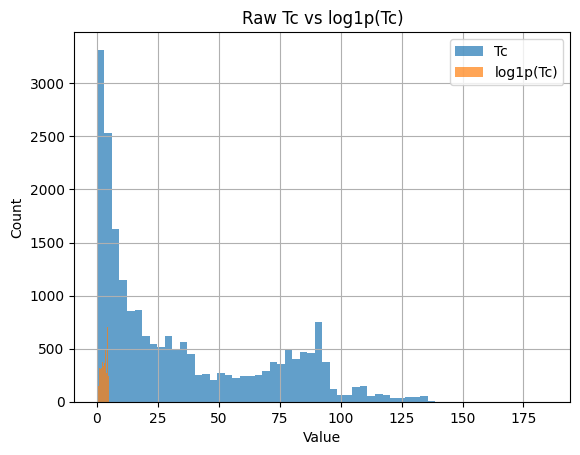

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.hist(df_train["critical_temp"].values, bins=60, alpha=0.7, label="Tc")
plt.hist(np.log1p(df_train["critical_temp"].values), bins=60, alpha=0.7, label="log1p(Tc)")
plt.legend(); plt.title("Raw Tc vs log1p(Tc)")
plt.xlabel("Value"); plt.ylabel("Count"); plt.grid(True); plt.show()

Because Tc is right-skewed, log1p(Tc) looks more balanced. We will train on log1p(Tc) and convert predictions back to Kelvin for the final metrics.

##**Split sanity: stratified by Tc deciles (train vs test distribution)**

We used decile stratification to keep the target distribution similar across train and test. This avoids bias from rare high-Tc
 samples clustering in one split. The decile percentages match by design; small differences exist but are hidden when rounding.

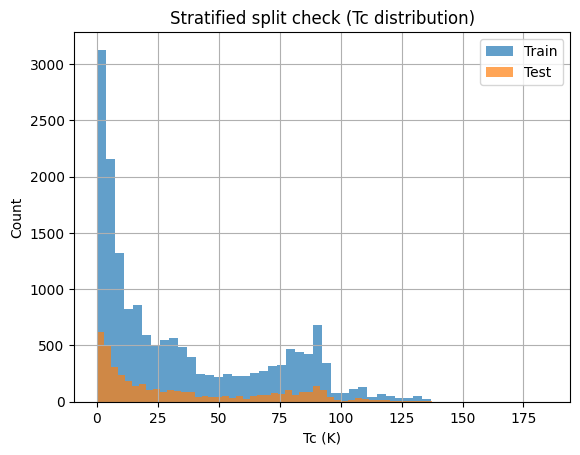

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np, pandas as pd, matplotlib.pyplot as plt

y = df_train["critical_temp"].values
bins = pd.qcut(y, q=10, labels=False, duplicates='drop')  # deciles 0..9
idx = np.arange(len(df_train))

# Train/Test split (20% test), stratified by deciles
idx_tr, idx_te = train_test_split(idx, test_size=0.2, random_state=42, stratify=bins)
y_tr, y_te = y[idx_tr], y[idx_te]
bins_tr, bins_te = bins[idx_tr], bins[idx_te]


# Overlay histograms (visual sanity check)
plt.figure()
plt.hist(y_tr, bins=50, alpha=0.7, label="Train")
plt.hist(y_te, bins=50, alpha=0.7, label="Test")
plt.title("Stratified split check (Tc distribution)")
plt.xlabel("Tc (K)"); plt.ylabel("Count"); plt.legend(); plt.grid(True); plt.show()

In [16]:
# More precision (3 decimals)
pct_tr = (pd.Series(bins_tr).value_counts(normalize=True).sort_index()*100)
pct_te = (pd.Series(bins_te).value_counts(normalize=True).sort_index()*100)
dist = pd.DataFrame({"train_%": pct_tr, "test_%": pct_te}).round(3)
display(dist)

# Absolute counts per decile (you’ll see small differences)
cnt_tr = pd.Series(bins_tr).value_counts().sort_index()
cnt_te = pd.Series(bins_te).value_counts().sort_index()
display(pd.DataFrame({"train_count": cnt_tr, "test_count": cnt_te}))

# Sanity: no index overlap between train and test
len(set(idx_tr) & set(idx_te))  # should be 0


,train_%,test_%
0,10.082,10.087
1,9.935,9.946
2,9.976,9.993
3,10.188,10.181
4,10.212,10.205
5,9.647,9.640
6,9.959,9.946
7,10.018,10.016
8,10.059,10.063
9,9.924,9.922


,train_count,test_count
0,1715,429
1,1690,423
2,1697,425
3,1733,433
4,1737,434
5,1641,410
6,1694,423
7,1704,426
8,1711,428
9,1688,422


0

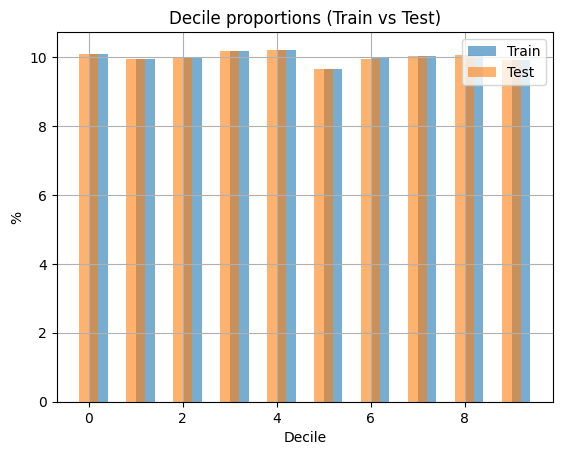

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.bar(range(len(pct_tr)), pct_tr, alpha=0.6, label="Train", align='edge', width=0.4)
plt.bar(range(len(pct_te)), pct_te, alpha=0.6, label="Test", width=0.4)
plt.legend(); plt.title("Decile proportions (Train vs Test)")
plt.xlabel("Decile"); plt.ylabel("%"); plt.grid(True); plt.show()


# **Part 2 : Modeling & Training - MLP Baseline with WSO & Fair Evaluation**

## **Making leak-safe splits (stratified by Tc deciles)**

In [18]:
# Train/Val/Test with decile stratification (Test=20%, Val=10% of total)
from sklearn.model_selection import train_test_split
import numpy as np, pandas as pd

y_all = df_train["critical_temp"].values
X_all = df_train[FEATURE_COLS].values

# stratify by deciles of Tc
bins_all = pd.qcut(y_all, q=10, labels=False, duplicates='drop')

idx_all = np.arange(len(df_train))
idx_trval, idx_te = train_test_split(
    idx_all, test_size=0.20, random_state=42, stratify=bins_all
)

# make a validation split inside the remaining 80%
bins_trval = pd.qcut(y_all[idx_trval], q=10, labels=False, duplicates='drop')
idx_tr, idx_val = train_test_split(
    idx_trval, test_size=0.125, random_state=42, stratify=bins_trval
)  # 0.125 of 0.80 = 0.10 overall

print("Train / Val / Test sizes:", len(idx_tr), len(idx_val), len(idx_te))

Train / Val / Test sizes: 14883 2127 4253


## **Standardize features (fit on train only)**

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr  = scaler.fit_transform(X_all[idx_tr])
X_val = scaler.transform(X_all[idx_val])
X_te  = scaler.transform(X_all[idx_te])

y_tr, y_val, y_te = y_all[idx_tr], y_all[idx_val], y_all[idx_te]

##**Define the MLP, training loop, and metrics**

In [20]:
# If PyTorch is missing (usually preinstalled on Colab), uncomment:
# !pip -q install torch torchvision torchaudio

import torch, numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class TcDataset(Dataset):
    def __init__(self, X, y, log_target=True):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(np.log1p(y) if log_target else y, dtype=torch.float32).view(-1,1)
        self.log_target = log_target
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

class MLP(nn.Module):
    def __init__(self, in_dim, hidden=256, layers=3, dropout=0.15):
        super().__init__()
        blocks, d = [], in_dim
        for _ in range(layers):
            blocks += [nn.Linear(d, hidden), nn.BatchNorm1d(hidden), nn.ReLU(), nn.Dropout(dropout)]
            d = hidden
        blocks += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*blocks)
    def forward(self, x): return self.net(x)

def eval_metrics(model, loader, log_target=True):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            p = model(xb.to(DEVICE)).cpu().numpy().reshape(-1)
            if log_target:
                p = np.expm1(p)
                y = np.expm1(yb.numpy().reshape(-1))
            else:
                y = yb.numpy().reshape(-1)
            ys.append(y); ps.append(p)
    y = np.concatenate(ys); p = np.concatenate(ps)
    r2  = r2_score(y, p)
    rmse= float(np.sqrt(mean_squared_error(y, p)))
    mae = mean_absolute_error(y, p)
    r   = float(np.corrcoef(y, p)[0,1])
    return {"R2": r2, "RMSE": rmse, "MAE": mae, "r": r}, (y, p)

def train_one(model, train_loader, val_loader, log_target=True,
              epochs=400, lr=1e-3, weight_decay=1e-5, patience=30):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
    best = {"rmse": float("inf"), "state": None}
    no_improve = 0
    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            loss = loss_fn(model(xb), yb)
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        # early stop on val RMSE
        m_val, _ = eval_metrics(model, val_loader, log_target)
        if m_val["RMSE"] < best["rmse"]:
            best["rmse"] = m_val["RMSE"]
            best["state"] = {k:v.cpu() for k,v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
        if no_improve >= patience: break
    if best["state"] is not None:
        model.load_state_dict(best["state"])
    return model

## **Quick WSO hyper-parameter search**

In [21]:
import numpy as np
from dataclasses import dataclass

@dataclass
class Config:
    hidden: int = 256
    layers: int = 3
    dropout: float = 0.15
    lr: float = 1e-3
    weight_decay: float = 1e-5
    batch_size: int = 256
    log_target: bool = True
    epochs: int = 300
    patience: int = 30

def decode(u):  # u in [0,1]^7 → Config
    widths = np.arange(128, 1025, 64)
    hidden = int(widths[int(np.clip(np.floor(u[0]*len(widths)),0,len(widths)-1))])
    layers = int(np.clip(2 + np.floor(u[1]*4), 2, 5))
    dropout= float(np.clip(u[2]*0.4, 0.0, 0.4))
    lr     = float(10**(np.log10(1e-4) + u[3]*(np.log10(5e-3)-np.log10(1e-4))))
    wd     = float(10**(np.log10(1e-6) + u[4]*(np.log10(1e-3)-np.log10(1e-6))))
    bchoices=[128,256,512,1024]
    bs     = int(bchoices[int(np.clip(np.floor(u[5]*len(bchoices)),0,len(bchoices)-1))])
    logt   = bool(u[6] >= 0.5)
    return Config(hidden, layers, dropout, lr, wd, bs, logt)

def wso_search(X_tr, y_tr, X_val, y_val, pop=8, iters=8, seed=42):
    rng = np.random.RandomState(seed)
    U = rng.rand(pop, 7)
    best = {"cfg": None, "rmse": float("inf")}
    hist = []
    for it in range(iters):
        vals = []
        for i in range(pop):
            cfg = decode(U[i])
            # data loaders
            tr_ds = TcDataset(X_tr, y_tr, log_target=cfg.log_target)
            va_ds = TcDataset(X_val, y_val, log_target=cfg.log_target)
            g = torch.Generator().manual_seed(seed + it*31 + i)
            tr_ld = DataLoader(tr_ds, batch_size=cfg.batch_size, shuffle=True, generator=g)
            va_ld = DataLoader(va_ds, batch_size=2048, shuffle=False)
            # model
            model = MLP(in_dim=X_tr.shape[1], hidden=cfg.hidden, layers=cfg.layers, dropout=cfg.dropout)
            model = train_one(model, tr_ld, va_ld, cfg.log_target, cfg.epochs, cfg.lr, cfg.weight_decay, cfg.patience)
            m, _ = eval_metrics(model, va_ld, cfg.log_target)
            vals.append(m["RMSE"])
            if m["RMSE"] < best["rmse"]:
                best = {"cfg": cfg, "rmse": m["RMSE"]}
        hist.append(min(vals))
        # exploitation around best + small noise
        a = 2*(1 - it/max(1,iters-1))
        for i in range(pop):
            r1, r2 = rng.rand(), rng.rand()
            A = 2*a*r1 - a; C = 2*r2
            D = np.abs(C*U[vals.index(min(vals))] - U[i])
            U[i] = np.clip(U[vals.index(min(vals))] - A*D + 0.1*rng.randn(7), 0, 1)
        print(f"Iter {it+1}/{iters} — best val RMSE: {best['rmse']:.3f}")
    return best["cfg"], hist

best_cfg, history = wso_search(X_tr, y_tr, X_val, y_val, pop=8, iters=8, seed=42)
best_cfg

Iter 1/8 — best val RMSE: 10.003
Iter 2/8 — best val RMSE: 9.887
Iter 3/8 — best val RMSE: 9.887
Iter 4/8 — best val RMSE: 9.887
Iter 5/8 — best val RMSE: 9.887
Iter 6/8 — best val RMSE: 9.887
Iter 7/8 — best val RMSE: 9.870
Iter 8/8 — best val RMSE: 9.544


Config(hidden=512, layers=4, dropout=0.0, lr=0.0001, weight_decay=1.442049817510422e-05, batch_size=512, log_target=False, epochs=300, patience=30)

## **Final train and Test evaluation**

In [22]:
# Train with best WSO config on Train; select by Val; report on Test once.
tr_ds = TcDataset(X_tr, y_tr, log_target=best_cfg.log_target)
va_ds = TcDataset(X_val, y_val, log_target=best_cfg.log_target)
te_ds = TcDataset(X_te, y_te, log_target=best_cfg.log_target)

tr_ld = DataLoader(tr_ds, batch_size=best_cfg.batch_size, shuffle=True)
va_ld = DataLoader(va_ds, batch_size=2048, shuffle=False)
te_ld = DataLoader(te_ds, batch_size=2048, shuffle=False)

model = MLP(in_dim=X_tr.shape[1], hidden=best_cfg.hidden, layers=best_cfg.layers, dropout=best_cfg.dropout)
model = train_one(model, tr_ld, va_ld, best_cfg.log_target,
                  epochs=best_cfg.epochs, lr=best_cfg.lr,
                  weight_decay=best_cfg.weight_decay, patience=best_cfg.patience)

test_metrics, (y_true, y_pred) = eval_metrics(model, te_ld, log_target=best_cfg.log_target)
test_metrics

{'R2': 0.9071603417396545,
 'RMSE': 10.457178991882166,
 'MAE': 6.260281562805176,
 'r': 0.9524902020174492}

##**Plots (ŷ vs y) and residuals**

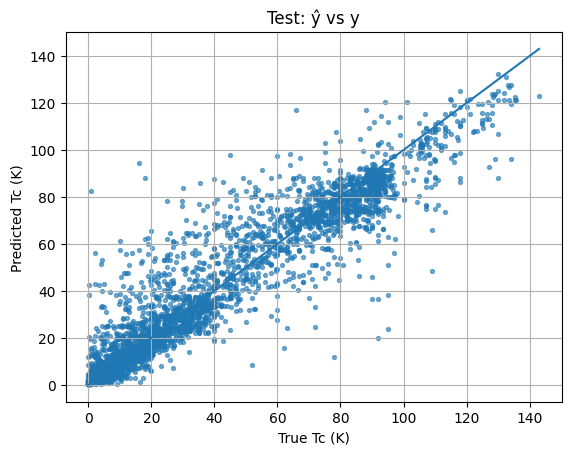

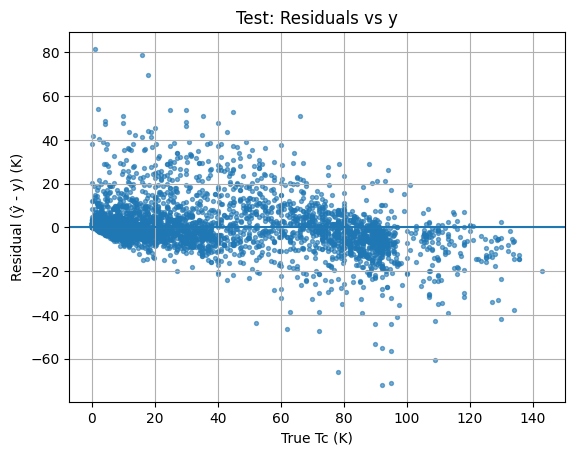

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.scatter(y_true, y_pred, s=8, alpha=0.6)
mn, mx = float(np.min(y_true)), float(np.max(y_true))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True Tc (K)")
plt.ylabel("Predicted Tc (K)")
plt.title("Test: ŷ vs y")
plt.grid(True); plt.show()

plt.figure()
res = y_pred - y_true
plt.scatter(y_true, res, s=8, alpha=0.6)
plt.axhline(0.0)
plt.xlabel("True Tc (K)")
plt.ylabel("Residual (ŷ - y) (K)")
plt.title("Test: Residuals vs y")
plt.grid(True); plt.show()

##**Permutation importance (fast, on Val set)**

In [24]:
def permutation_importance(model, X_base, y_base, repeats=3, log_target=True):
    base_ds = TcDataset(X_base, y_base, log_target=log_target)
    base_ld = DataLoader(base_ds, batch_size=2048, shuffle=False)
    base_m, (yt, yp) = eval_metrics(model, base_ld, log_target)
    base_rmse = base_m["RMSE"]

    rng = np.random.RandomState(42)
    importances = []
    X_mut = X_base.copy()
    for j in range(X_base.shape[1]):
        scores = []
        for _ in range(repeats):
            idx = rng.permutation(len(X_base))
            X_mut[:, j] = X_base[idx, j]     # shuffle feature j
            ds = TcDataset(X_mut, y_base, log_target=log_target)
            ld = DataLoader(ds, batch_size=2048, shuffle=False)
            m, (yt2, yp2) = eval_metrics(model, ld, log_target)
            scores.append(m["RMSE"])
            X_mut[:, j] = X_base[:, j]       # restore
        importances.append(np.mean(scores) - base_rmse)  # RMSE increase
    return importances

imps = permutation_importance(model, X_val, y_val, repeats=3, log_target=best_cfg.log_target)
imp_df = pd.DataFrame({"feature": FEATURE_COLS[:len(imps)], "rmse_increase": imps}).sort_values("rmse_increase", ascending=False)
imp_df.head(15)

,feature,rmse_increase
27,range_atomic_radius,13.395540
76,wtd_entropy_Valence,13.224515
80,wtd_std_Valence,12.353581
79,std_Valence,8.693510
35,entropy_Density,8.625182
7,range_atomic_mass,8.156751
50,wtd_std_ElectronAffinity,7.961244
42,wtd_mean_ElectronAffinity,7.747957
66,wtd_entropy_ThermalConductivity,7.746442
12,wtd_mean_fie,7.607413
